In [1]:
from sympy import *
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import fsolve
from collections import Counter
from scipy.integrate import odeint
from scipy.linalg import null_space
import time

init_printing() 

In [2]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
def arrange_comp(ccm_comp_len, comp_len):
    var_only = []
    cov_only = []
    sp_only = []
    var_sp = []

    p = 0
    c = ccm_comp_len - comp_len
    for i in range(comp_len):
        for j in range(i,comp_len):
            if j == i:
                var_only.append(p)
                sp_only.append(c)
                var_sp.append(c)
                var_sp.append(p)
                c = c + 1
            else:
                cov_only.append(p)

            p = p + 1    

    return np.array([*var_sp, *cov_only])

In [3]:
done_parsing = set()
def process(x):
    global done_parsing
    xx =  x.strip("*").strip().replace("*/","/")
    if xx[0] == "/":
        xx = "1"+xx
    if xx[-1] == "/":
        xx = xx.strip("/")
    val = sympify(xx.strip("*"))
    if val in done_parsing:
        return None
    else:
        done_parsing.add(val)
    return val

def propExt(expr,prop):
    ex = str(expr)
    open = 0
    close = 0
    diff = 0

    collect = ""
    for v in ex:
        if v in ["+","-"] and diff == 0:
            if len(collect)>0:
                d = process(collect)
                if d != None:
                    prop.append(d)
                collect = ""
                open = 0
                close = 0
        elif v == "(":
            open = open + 1
            collect = collect + v
        elif v == ")":
            close = close + 1
            collect = collect + v
        elif (v.isnumeric() or v == ".") and (diff == 0):
            if len(collect)>=3:
                if collect[-2:] == "**" or collect[-1] not in ["*","/"]:
                    collect = collect + v
            elif len(collect)>=1:
                if collect[-1] not in ["*","/"," "]:
                    collect = collect + v
            else:
                pass
        else:
            collect = collect + v	
        diff = open - close

    d = process(collect)
    if d != None:
        prop.append(d)

def termExt(expr):
    term = []
    ex = str(expr)
    open = 0
    close = 0
    diff = 0

    collect = ""
    last_sign = ""
    for v in ex:
        if v in ["+","-"] and diff == 0:
            if len(collect)>0:
                term.append(last_sign+collect)
                collect = ""
                open = 0
                close = 0
            last_sign = v
        elif v == "(":
            open = open + 1
            collect = collect + v
        elif v == ")":
            close = close + 1
            collect = collect + v
        else:
            collect = collect + v	
        diff = open - close

    term.append(last_sign+collect)
    return term

def get_prop_stoich(dxdt):
    prop = []
    dAdt = []
    for expro in dxdt:
        expr = expand(sympify(expro))
        propExt(expr,prop)
        dAdt.append(expr)

    w = prop
    V = [[0 for x in range(len(w))] for y in range(len(dAdt))]

    for i in range(len(dAdt)):
        for j in range(len(w)):
            s = 0
            for xx in termExt(dAdt[i]):
                x = sympify(xx)/w[j]
                try:
                    s = s + float(x)
                except:
                    pass
            V[i][j] = s

    return Matrix(V), Matrix(w)

def print_stoich_prop(dxdt):
    global done_parsing
    done_parsing = set()
    print()
    V, w = get_prop_stoich(dxdt)
    for t in V*w:
        print(t)
    print()

    for c in np.array(V):
        print([round(y,4) for y in c])
    print()

    for c in np.array(w):
        print(c)

def transform_to_rxn(x,dxdt):
    global done_parsing
    done_parsing = set()
    V, w = get_prop_stoich(dxdt)
    S = np.around(np.array(V).astype(float),3)
    Rxn = []
    Ksn = set()
    ind = 0 

    for col in S.T:
        R = ""
        P = ""
        for i in range(len(col)):
            if col[i] != 0:
                if col[i]<0:
                    R = R + str(abs(col[i]))+" "+x[i] +" "+ "+ "
                else:
                    P = P + str(abs(col[i]))+" "+x[i] +" "+ "+ "
        if R.strip() == "":
            R = "0 NONE"
        if P.strip() == "":
            P = "0 NONE"

        inSp = []
        for s in w[ind].free_symbols:
            ss = str(s)
            if ss in x:
                inSp.append(ss)
            else:
                Ksn.add(ss)
        inSp = ",".join(inSp)
        print(
            R.strip("+ ")+" => "+P.strip("+ ")+", 1 ::::: lambda "+inSp+" : "+str(w[ind])
        )
        ind = ind + 1

In [4]:
time_ini = time.time()

t = Symbol('t', real = True, nonnegative=True)
A, B, C, D, E, F, G, H, I, J = symbols('A, B, C, D, E, F, G, H, I, J', real=True, positive=True)  

k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15 = symbols('k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15',real=True,positive=True)
rate_constants = [k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15]
components = [A, B, C, D, E, F, G, H, I, J]

Stoich_mat = Matrix([
    #r1  r2  r3  r4  r5  r6  r7  r8  r9  r10  r11  r12  r13  r14  r15
     [1,  0, -1,  0,  0,  0,  0,  0,  0,  0,   0,   0,   0,   0,   0], #a
     [0,  1,  0, -1,  0,  0,  0,  0,  0,  0,   0,   0,   0,   0,   0], #b
     [0,  0,  1,  0, -1, -1,  0,  0,  0,  0,   1,   0,   0,   0,   0], #c
     [0,  0,  0,  1,  1,  0, -1,  0,  0,  0,   0,   0,   0,   0,   0], #d
     [0,  0,  0,  0,  0,  1,  0,  1, -1,  0,   0,   0,   0,   0,   0], #e
     [0,  0,  0,  0,  0,  0,  1, -1,  0, -1,   0,   0,  -1,   0,   0], #f
     [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  -1,  -1,   0,   0,   0], #g
     [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,   0,  -1,   0,   0,   0], #h
     [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,   0,   1,   0,  -1,   0], #i
     [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,   0,   0,   1,   0,  -1], #j
])

Prop_vec  = Matrix([
    k1,
    k2,
    k3*A,
    k4*B,
    k5*C,
    k6*C,
    k7*D,
    k8*F,
    k9*E,
    k10*F,
    k11*G,
    k12*G*H,
    k13*F,
    k14*I,
    k15*J
])   

dX_dt = Stoich_mat*Prop_vec
Aj = dX_dt.jacobian(components)
Prop_vec_F = diag(*Prop_vec )
BBT = Stoich_mat*Prop_vec_F*Stoich_mat.T

comp_len = len(components)
rate_len = len(rate_constants)

################################################################

response_zero_threshold    = 1.0e-10
pseudo_comp_zero_threshold = 1.0e-10
num_sampling = 100
rdigit = 8

################################################################

Cov = Matrix([ 
    [var("C_"+str(components[i])+str(components[j])) for j in range(comp_len)] 
    for i in range(comp_len) 
])

dsub = []
for i in range(comp_len):
    for j in range(i,comp_len):
        Cov[j,i] = Cov[i,j]

dCov_dt = Aj*Cov + Cov*Aj.T + BBT     

Eqs_to_solve = []
ccm_components = []

for i in range(dCov_dt.shape[0]):
    for j in range(i,dCov_dt.shape[0]):
        Eqs_to_solve.append(dCov_dt[i,j].subs(dsub))
        ccm_components.append(Cov[i,j])

for i in range(dX_dt.shape[0]):
    Eqs_to_solve.append(dX_dt[i])
    ccm_components.append(components[i])
    
ccm_comp_len = len(ccm_components)
    
zz_Prop_vec = Matrix([ Eqs_to_solve[i] for i in range(ccm_comp_len)])
ss_components = [ str(ccm_components[i]) for i in range(ccm_comp_len) ]
zz_Prop_vec = [ x for x in zz_Prop_vec if x!=0]

done_parsing = set()
Sp_stoich, fp_Prop = get_prop_stoich(zz_Prop_vec)
fp_Prop = Matrix([ eval(str(x)) for x in fp_Prop ])

kerV = null_space(np.array(Sp_stoich).astype(np.float64))

Ajnew = fp_Prop.jacobian(ccm_components)
Ajnew = Ajnew.col_insert(Ajnew.shape[1],-Matrix(kerV))
Ajnew = lambdify([*ccm_components, *rate_constants], Ajnew)

Jfp_func = lambdify([*ccm_components, *rate_constants],fp_Prop.jacobian(rate_constants).T)
xfunct_ini = lambdify([*ccm_components, *rate_constants], Eqs_to_solve)
xfunct_model = lambda x, y : xfunct_ini(*[*x,*y])

data_fluc = []
index_iter = 0
while index_iter<num_sampling:
    try:
    #if True:
        done_parsing = set()


        kvals = np.random.uniform(80,200,rate_len)  
        ini_cc_val = [ np.random.uniform(0,10) for x in ccm_components ]            
        sol_var = fsolve(xfunct_model, ini_cc_val, args=(kvals), maxfev=1000*len(ini_cc_val))   
        solv_len = len(sol_var)
                
        p = 0
        val_checks = True
        comp_len_dec = comp_len
        while comp_len_dec>0:
            val_checks = val_checks and sol_var[p]>0
            p += comp_len_dec
            comp_len_dec -= 1
            
        for i  in range(1,comp_len+1):
            val_checks = val_checks and sol_var[-i]>0
        
        if val_checks:
            print("iterations =",index_iter+1,end="\r") 
        
            Nans = np.linalg.inv(np.array(Ajnew(*[*sol_var, *kvals]).astype(np.float64)))
            Jfpks = np.array(Jfp_func(*[*sol_var, *kvals]))

            ans = np.zeros((ccm_comp_len, rate_len))
            thr = pseudo_comp_zero_threshold
            for i in range(rate_len):
                col = np.zeros((ccm_comp_len,1))
                for j in range(Jfpks.shape[1]):
                    if Jfpks[i,j] != 0:
                        hold_Nans = np.zeros((ccm_comp_len,1))
                        for hi in range(ccm_comp_len): 
                            
                            if Jfpks[i,j] == 1:
                                hold_Nans[hi] = np.round_(Nans[hi,j]*kvals[i],rdigit)
                            elif abs(Jfpks[i,j]) > thr and abs(sol_var[hi])>thr:
                                hold_Nans[hi] = np.round_(Nans[hi,j]*Jfpks[i,j]*kvals[i],rdigit)
                                                                                    
                        col = col + hold_Nans
                        
                ans[:,i] = col[:,0]

            thr = response_zero_threshold
            for i in range(ans.shape[0]):    
                for j in range(ans.shape[1]):
                                
                    val = ans[i,j]
                    if val>thr:
                        ans[i,j] = 1 
                    elif val<-thr:
                        ans[i,j] = -1 
                    else:
                        ans[i,j] = 0                            

            col = []
            for i in range(ans.shape[0]):
                try:
                    col.append("$"+str(ccm_components[i]).replace("_","_{")+"}"+"$")
                except:
                    pass

            label_list = [ "$"+str(x).replace("k","k_{")+"}"+"$" for x in rate_constants ]
            data = np.array(ans[0:len(col),:],dtype=float).T

            data_fluc.append(data)
            index_iter = index_iter + 1
    except:
        pass
    
print(time.time()-time_ini)

C:\Users\efaji\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


C:\Users\efaji\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


66.66186380386353


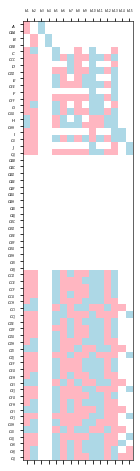

In [5]:
dd = np.array(data_fluc)
order_comp = arrange_comp(ccm_comp_len, comp_len)
dd = dd[:,:,order_comp]

np.save("special.npy", dd, allow_pickle=True)


data = np.zeros((65,15))

for i in range(15):
    for j in range(65):
        c = Counter(np.round(dd[:,i,j],3))
        sizes = []
        for v in [-1,0,1]:
            if v in c:
                sizes.append(c[v])
            else:
                sizes.append(0)
        data[j,i] = np.argmax(sizes)-1


plt.rc('xtick', labelsize=4)
plt.rc('ytick', labelsize=4)
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['font.family'] = "DejaVu Sans"

    
plt.figure(figsize=cm2inch(5,20))
plt.matshow(
    data,
    fignum=1,
    aspect="auto",
    interpolation=None,vmin=-1, vmax=2,
    cmap=ListedColormap(['lightpink', 'white','lightblue','lightgrey'])
)

components = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
col = []
for i in range(10):
    for j in range(i,10):
        col.append("$C_{"+components[i]+components[j]+"}$")
               
for i in range(10):
    col.append("$"+components[i]+"$")
    
col = [ col[i] for i in order_comp ]

plt.xticks(ticks=range(15),labels=[ "$k_{"+str(x+1)+"}"+"$" for x in range(15) ])
plt.yticks(ticks=range(65),labels=col)

plt.savefig("special.png",dpi=300,bbox_inches='tight')